Concept and viz inspired by Twitter user @11tegen11 / http://11tegen11.net

Data provided by Statsbomb

In [102]:
# import relevant libraries
%matplotlib inline
import json
from pandas.io.json import json_normalize
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from lib.find_game import find_games_by_team

## GET DATA

First let's find games played by Poland in the FIFA World Cup 2018 in statsbomb open-data repository.

In [4]:
games = find_games_by_team('Poland')
game_ids = games['match_id'].unique()

In [5]:
games[['match_id', 'home_team_home_team_name', 'away_team_away_team_name', 'home_score', 'away_score']]

,match_id,home_team_home_team_name,away_team_away_team_name,home_score,away_score
33,7555,Poland,Colombia,0,3
39,7539,Poland,Senegal,1,2
60,7572,Japan,Poland,0,1


Having their IDs I can load them to a DataFrame

In [6]:
data_id = game_ids
# consequently read the json and concatenate into a pre-defined dataframe
all_pol = pd.DataFrame()
for i in data_id:
    with open(r'football_analysis/open-data/data/events/'+str(i)+'.json', encoding='utf-8') as data_file:
        data = json.load(data_file)
    df = json_normalize(data, sep = '_')
    df['game_id'] = i
    if all_pol.empty:
        all_pol = df
    else:
        all_pol = pd.concat([all_pol, df], join = 'outer', sort = False)

Now, let's split it game by game

In [7]:
df = all_pol
pol_sen = df.loc[df['game_id'] == 7539]
pol_col = df.loc[df['game_id'] == 7555]
jap_pol = df.loc[df['game_id'] == 7572]

In [65]:
#select game to work on
df = pol_col.copy()

In [66]:
df['goal'] = np.where((df['shot_outcome_name'] == 'Goal') | (df['type_name'] == 'Own Goal For'),1,0)

In [67]:
teams = df['team_name'].unique()

In [70]:
game_result = df.groupby('team_name').sum()[['shot_statsbomb_xg', 'goal']]
game_result

,shot_statsbomb_xg,goal
team_name,,
Colombia,1.352031,3
Poland,0.754484,0


## accumulated xG before scoring a goal

In [71]:
chances_time = df.loc[df['shot_outcome_name'].isna() == False][['minute', 'team_name', 'player_name', 'shot_outcome_name', 'shot_statsbomb_xg']]

chances_time['chance_home'] = np.where(chances_time['team_name'] == teams[0],chances_time['shot_statsbomb_xg'],0)
chances_time['chance_away'] = np.where(chances_time['team_name'] == teams[1],chances_time['shot_statsbomb_xg'],0)

chances_time['acc_xg_home'] = np.add.accumulate(chances_time['chance_home'])
chances_time['acc_xg_away'] = np.add.accumulate(chances_time['chance_away'])

goals_time = chances_time.loc[chances_time['shot_outcome_name'] == 'Goal']

In [100]:
chances_time.head()

,minute,team_name,player_name,shot_outcome_name,shot_statsbomb_xg,chance_pol,chance_col,chance_home,chance_away,acc_xg_home,acc_xg_away
54,1,Poland,Dawid Kownacki,Blocked,0.018315,0.018315,0.000000,0.018315,0.000000,0.018315,0.000000
165,4,Poland,Robert Lewandowski,Wayward,0.169242,0.169242,0.000000,0.169242,0.000000,0.187557,0.000000
572,14,Colombia,Santiago Arias Naranjo,Blocked,0.015998,0.000000,0.015998,0.000000,0.015998,0.187557,0.015998
706,17,Poland,Piotr Zieliński,Blocked,0.022515,0.022515,0.000000,0.022515,0.000000,0.210072,0.015998
1207,34,Colombia,Juan Guillermo Cuadrado Bello,Off T,0.012081,0.000000,0.012081,0.000000,0.012081,0.210072,0.028079


In [99]:
goals_time

,minute,team_name,player_name,shot_outcome_name,shot_statsbomb_xg,chance_pol,chance_col,chance_home,chance_away,acc_xg_home,acc_xg_away
1467,39,Colombia,Yerry Fernando Mina González,Goal,0.385861,0.0,0.385861,0.0,0.385861,0.210072,0.413940
2938,69,Colombia,Radamel Falcao García Zárate,Goal,0.380053,0.0,0.380053,0.0,0.380053,0.473017,0.997395
3092,74,Colombia,Juan Guillermo Cuadrado Bello,Goal,0.242940,0.0,0.242940,0.0,0.242940,0.487467,1.240335


Text(0.1, 0.05, 'source: Ekstrastats')

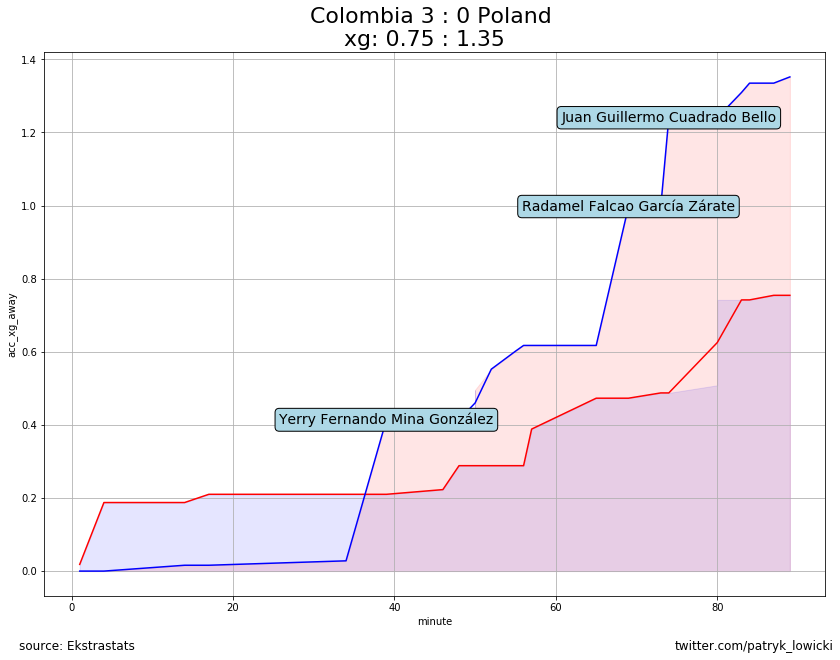

In [98]:
fig, ax = plt.subplots()
fig.set_size_inches(14, 10)

plt.title(f"{game_result.index[0]} {game_result.goal[0]} : {game_result.goal[1]} {game_result.index[1]} \n xg: {round(chances_time['acc_xg_home'].iloc[-1], 2)} : {round(chances_time['acc_xg_away'].iloc[-1], 2)}    ", fontdict={'fontsize' : 22})


#LINES
sns.lineplot(data=chances_time, x='minute', y='acc_xg_home', ax=ax, color='red')
sns.lineplot(data=chances_time, x='minute', y='acc_xg_away', ax=ax, color='blue')

#DOTS
sns.scatterplot(data=goals_time.loc[goals_time['team_name'] == teams[0]],   x='minute', y='acc_xg_home', s=200, ax=ax, color='red')
sns.scatterplot(data=goals_time.loc[goals_time['team_name'] == teams[1]], x='minute', y='acc_xg_away', s=200, ax=ax, color='blue')

#TEXT

bbox_props = dict(boxstyle="round", fc='red')

for i in range(len(goals_time)):
    row = goals_time.iloc[i]
#     playername = row['player_name'].split(' ')[-1]
    playername = row['player_name']
    
    if row['team_name'] == teams[0]:      
        ax.text(row['minute'], row['acc_xg_home'], playername, 
                ha='center', va='center', size=14, bbox=dict(boxstyle="round", fc='lightcoral'))
    
    else:
        ax.text(row['minute'], row['acc_xg_away'], playername, 
                ha='center', va='center', size=14, bbox=dict(boxstyle="round", fc='lightblue'))

    
        


#FILL AREA BETWEEN LINE AND X 
plt.fill_between(chances_time['minute'], chances_time['acc_xg_home'], alpha=0.1, color='blue')  
plt.fill_between(chances_time['minute'], chances_time['acc_xg_away'], alpha=0.1, color='red')          
        
plt.grid()

#IMAGE TEXT
plt.gcf().text(0.75, 0.05, 'twitter.com/patryk_lowicki', fontsize=12)
plt.gcf().text(0.1, 0.05,  'source: Statsbomb', fontsize=12)  